In [88]:
from dataLoader import DataSet
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model, Model
%matplotlib inline
import cv2 
import keras
import tensorflow as tf
from skimage.transform import pyramid_expand

In [86]:
fold = '/home/athira/Codes/AttentionModel/attention/'
file  = fold + 'eval_test.npy'
data = np.load(file).item()
imgs = data['imgs']; labels = data['area']; 
pred = data['predictions'].reshape([-1])*100; 
alphas = data['alphas']; indx = data['indx'];
fnames = data['fileNames']

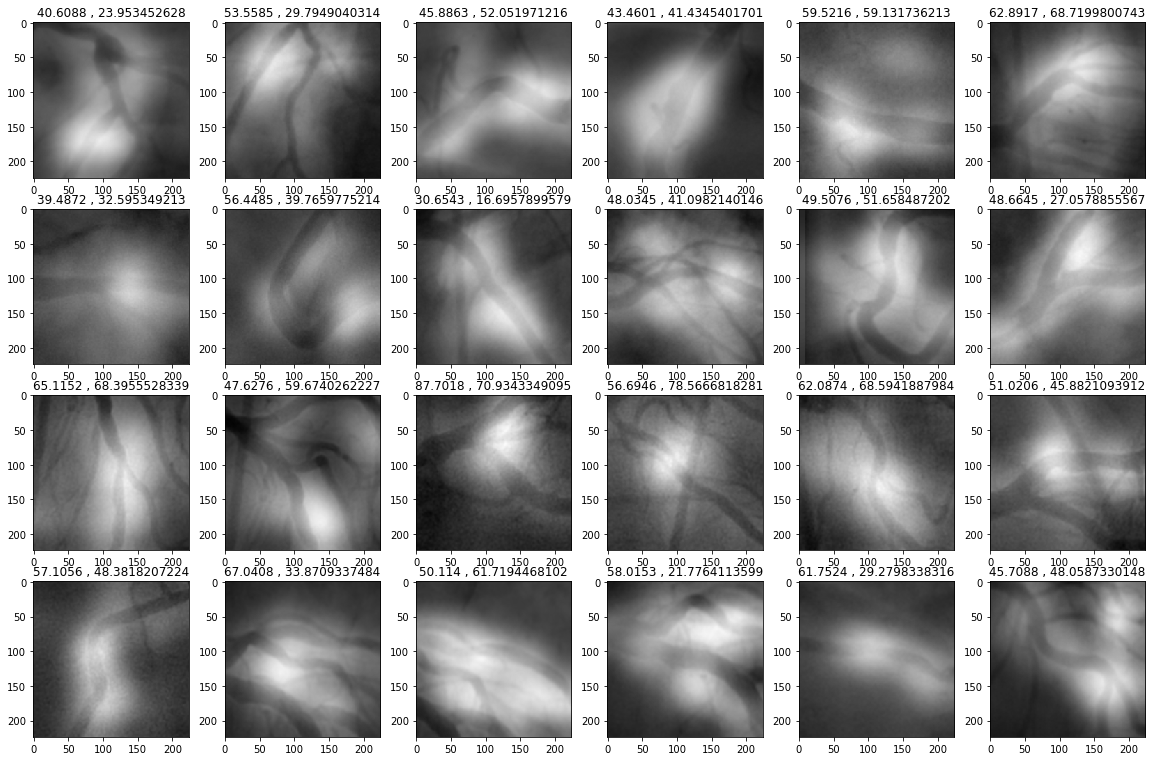

In [91]:
plt.figure(figsize = (20,20))
for i in range(24):
    plt.subplot(6,6,i+1);
    plt.imshow(imgs[i,:,:,0], cmap = 'gray')
    alp_curr = alphas[i,:].reshape(14,14)
    alp_img = pyramid_expand(alp_curr, upscale=16, sigma=20)
    plt.imshow(alp_img, alpha=0.75, cmap = 'gray')
    plt.title(str(pred[i]) + " , " + str(labels[i]))

In [92]:
alp_img

array([[ 0.00270267,  0.00270582,  0.00271211, ...,  0.00477477,
         0.00476461,  0.00475951],
       [ 0.00270392,  0.00270708,  0.00271338, ...,  0.00477964,
         0.00476946,  0.00476434],
       [ 0.00270642,  0.00270959,  0.00271592, ...,  0.00478936,
         0.00477911,  0.00477398],
       ..., 
       [ 0.0019102 ,  0.00190973,  0.00190878, ...,  0.00238373,
         0.00237463,  0.00237006],
       [ 0.00190833,  0.00190785,  0.0019069 , ...,  0.00237762,
         0.00236853,  0.00236397],
       [ 0.00190739,  0.00190691,  0.00190596, ...,  0.00237456,
         0.00236548,  0.00236093]])

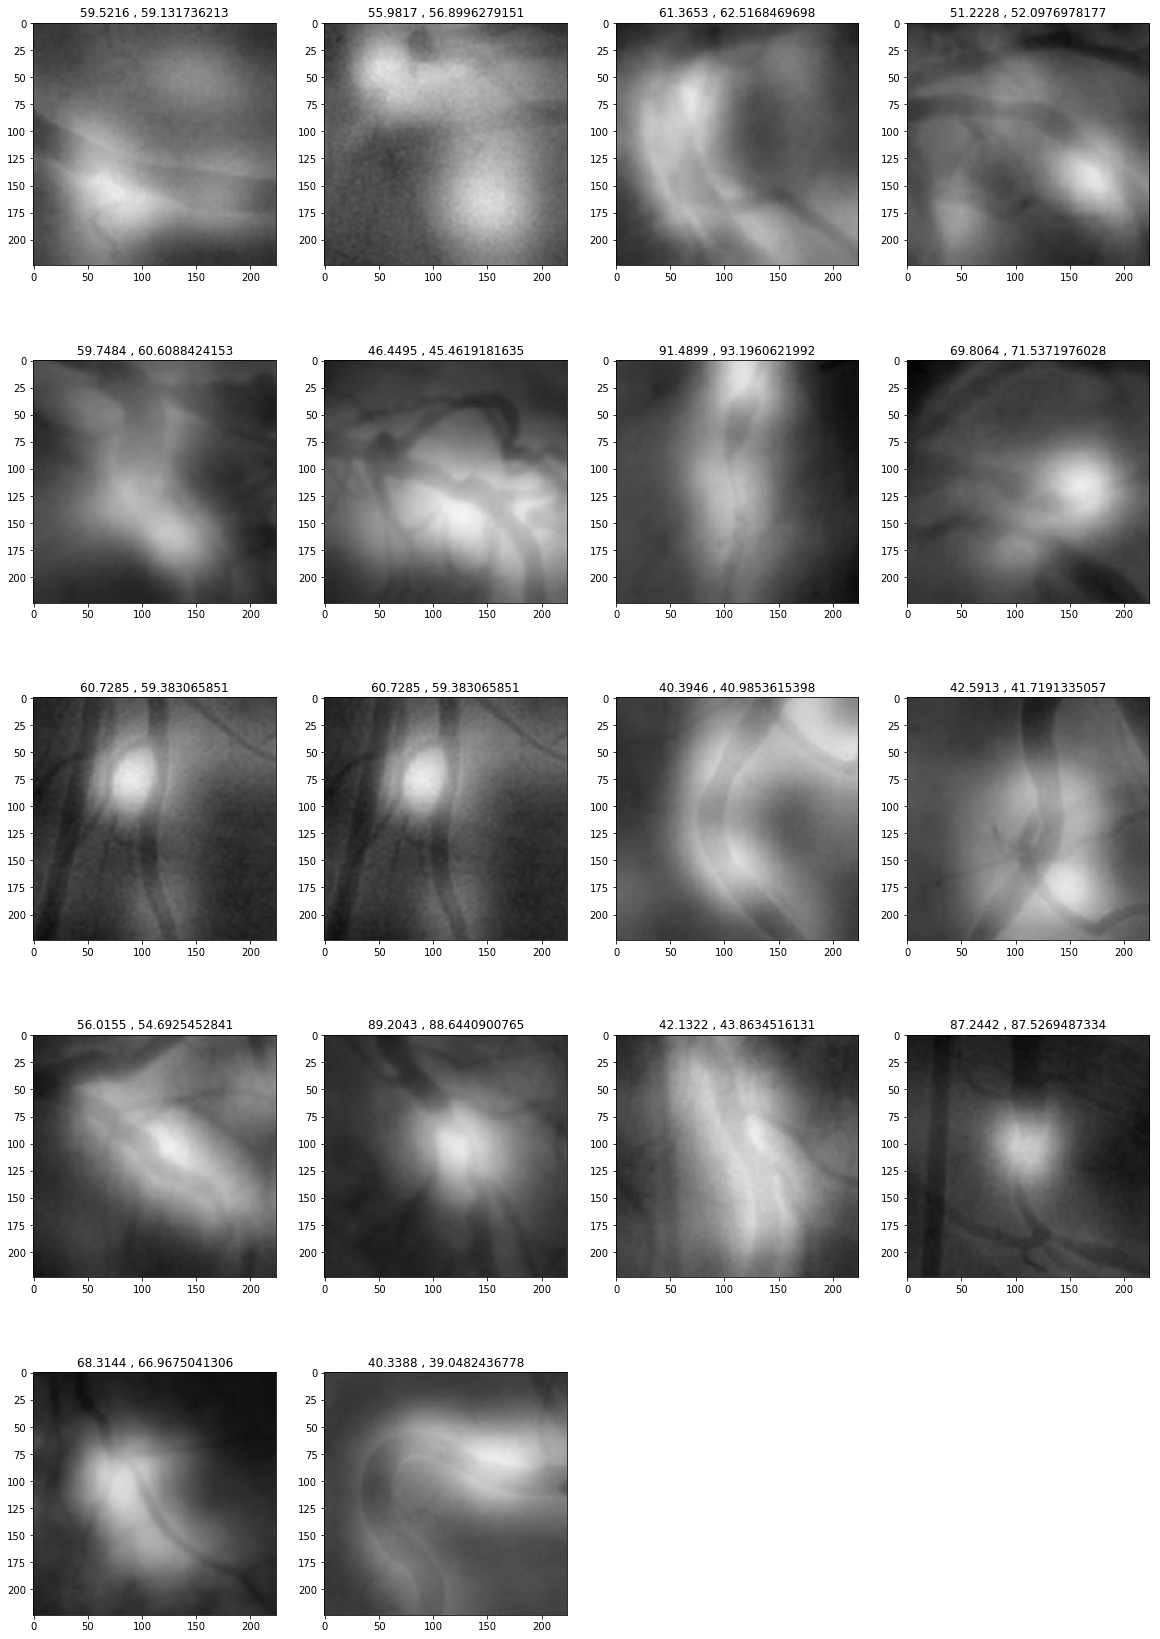

In [50]:
#Best
diff = pred - labels
sub = np.abs(diff)<2
imgs_sub = imgs[sub]; labels_sub = labels[sub]
pred_sub = pred[sub]; alphas_sub = alphas[sub]
plt.figure(figsize = (20,30))
for i in range(18):
    plt.subplot(5,4,i+1);
    plt.imshow(imgs_sub[i,:,:,0], cmap = 'gray')
    alp_curr = alphas_sub[i,:].reshape(14,14)
    alp_img = pyramid_expand(alp_curr, upscale=16, sigma=20)
    plt.imshow(alp_img, alpha=0.75, cmap = 'gray')
    plt.title(str(pred_sub[i]) + " , " + str(labels_sub[i]))


In [ ]:
def readUncomp(fname):
	RefDs = dicom.read_file(fname)
	# ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
	# ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))
	# x = numpy.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
	# y = numpy.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
	# z = numpy.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])
	# ArrayDicom = numpy.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
	pix = RefDs.pixel_array
	return RefDs, pix

def readQCA(ds):
	header = dict() #Dictionary to store relevant info
	tag = ds[0x08, 0x1140].value[0]
	header['SOPInstanceUID'] = tag[0x08,0x1155].value
	num = len(ds[0x7901,0x1099].value)
	
	header['num'] = num  #Number of obstructions. 
	header['Frame'] = []
	header['Obstruction Diameter'] = []
	header['Reference Diameter'] = []
	header['Diameter Stenosis'] = []
	header['Area Stenosis'] = []
	header['Obstruction Length'] = []
	header['Original,Upper'] = []
	header['Original,Lower'] = []
	header['Lesion,Upper'] = []
	header['Lesion,Lower'] = []
	header['Midline'] = []

	for i in range(num): #Iterate through each obstruction defined
		tags = ds[0x7901,0x1099].value[i]
		header['Frame'].append(tags[0x7903,0x1021].value + 1)
		tags = tags[0x7903, 0x1099].value[0] 
		header['Obstruction Diameter'].append(tags[0x7905, 0x1051].value) #in mm
		header['Lesion,Upper'].append(tags[0x7905,0x1071].value)
		header['Lesion,Lower'].append(tags[0x7905,0x1072].value)
		header['Original,Upper'].append(tags[0x7905,0x1074].value)
		header['Original,Lower'].append(tags[0x7905,0x1075].value)
		header['Midline'].append(tags[0x7905,0x107D].value)
		tags = tags[0x7905,0x1099].value[0]
		header['Reference Diameter'].append(tags[0x7909,0x1034].value)  #in mm
		header['Diameter Stenosis'].append(tags[0x7909,0x1035].value) #in %
		header['Area Stenosis'].append(tags[0x7909,0x1040].value)  #in %
		header['Obstruction Length'].append(tags[0x7909,0x1069].value)  #in mm

	return header


def get_lesion(name, fname):
    a = name
    pnum = int(a.split('_')[1])
    file = int(a.split('_')[2])
    case = int(a.split('_')[2].split('.')[0])
    meta, vol = readUncomp(fname)
    qca_info = readQCA(meta)
    PATCH_SIZE = 128
    BORDER = int(PATCH_SIZE/2)
    padded_img = cv2.copyMakeBorder(img,BORDER,BORDER,BORDER,BORDER,cv2.BORDER_CONSTANT,value = int(np.mean(img)))

    orig_upper = qca_info['Original,Upper'][case - 1]
    orig_lower = qca_info['Original,Lower'][case - 1]

    xu = np.array(orig_upper[0::2]);yu = np.array(orig_upper[1::2]);
    xl = np.array(orig_lower[0::2]);yl = np.array(orig_lower[1::2]);
    x_min = np.amin(np.concatenate([xu,xl])); y_min = np.amin(np.concatenate([yu,yl]))
    x_max = np.amax(np.concatenate([xu,xl])); y_max = np.amax(np.concatenate([yu,yl]))
    x_centre = int((x_min+x_max)/2); y_centre = int((y_min+y_max)/2); 
    
    return qca['Area Stenosis'], (x_min,y_min), (x_max, y_max)
    
    

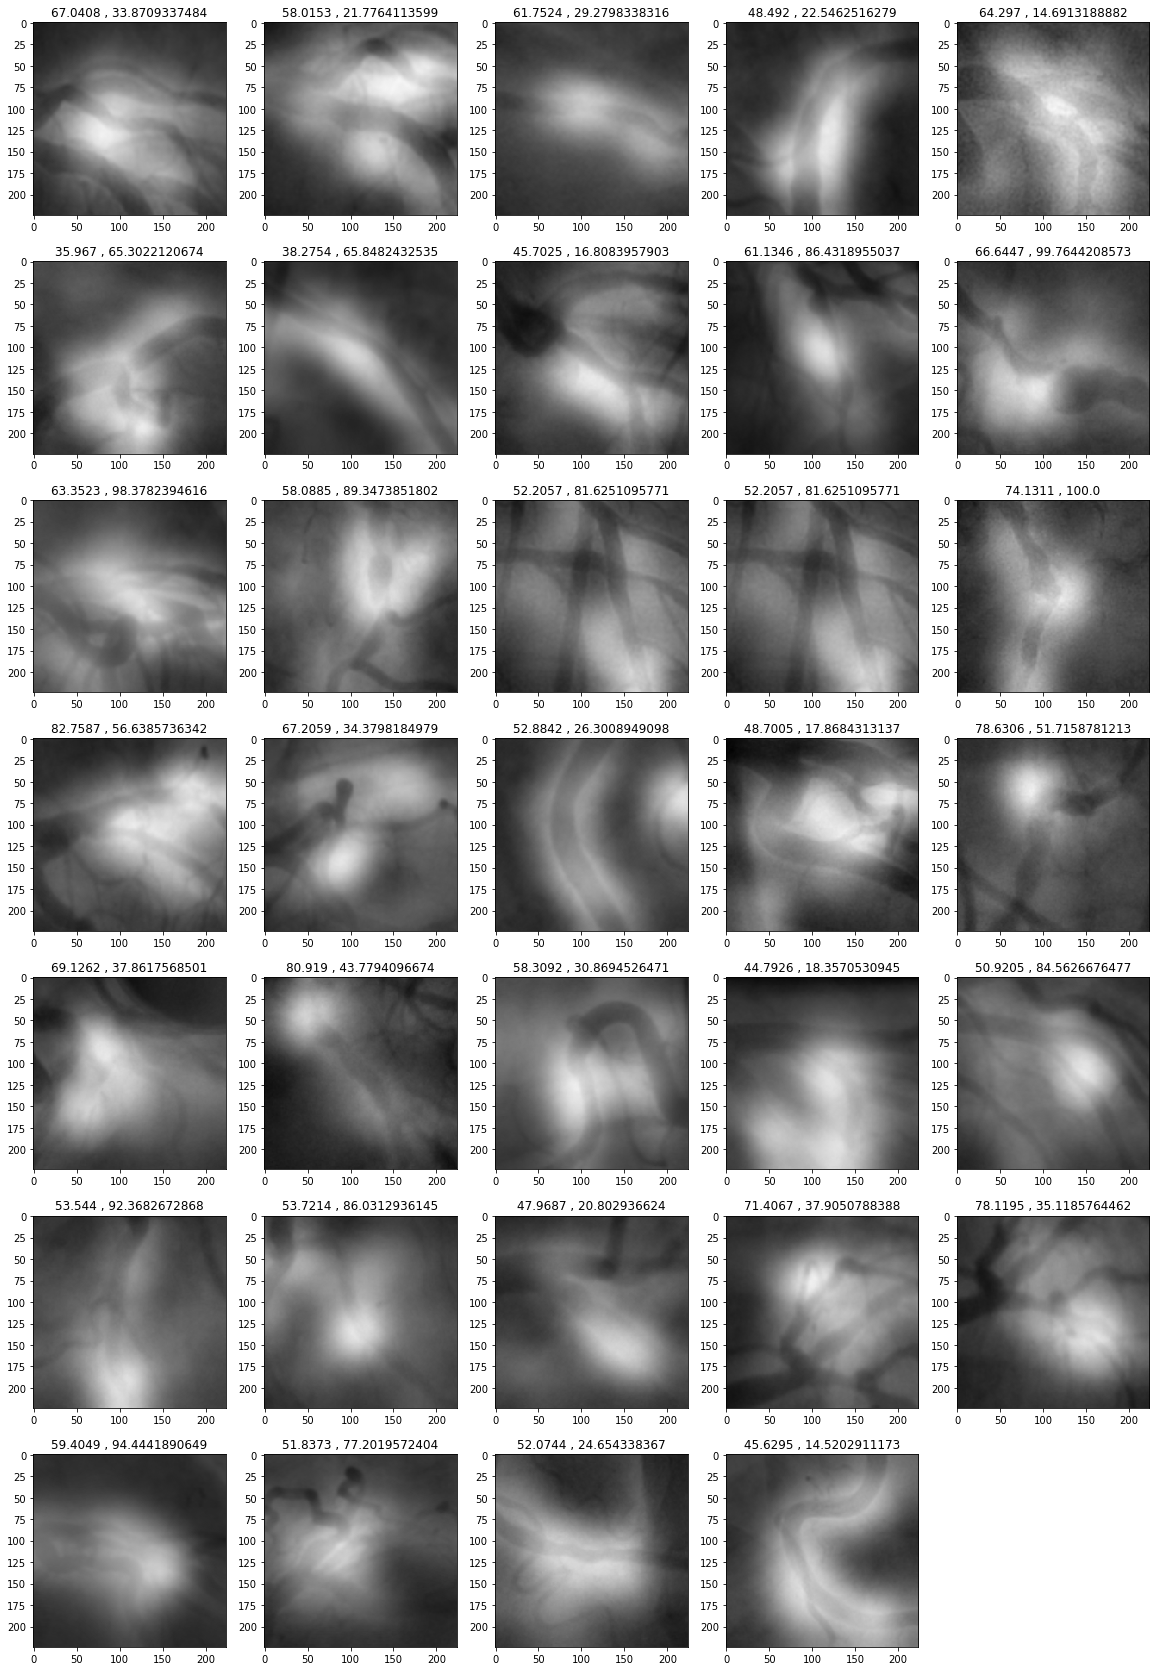

In [51]:
#Worst
diff = pred - labels
sub = np.abs(diff)>25
imgs_sub = imgs[sub]; labels_sub = labels[sub]
pred_sub = pred[sub]; alphas_sub = alphas[sub]
indx_sub = [indx[i] for i in range(len(indx)) if sub[i] == True]
fname_sub = [fnames[i] for i in range(len(fnames)) if sub[i] == True]
plt.figure(figsize = (20,30))
for i in range(34):
    plt.subplot(7,5,i+1);
    plt.imshow(imgs_sub[i,:,:,0], cmap = 'gray')
    alp_curr = alphas_sub[i,:].reshape(14,14)
    alp_img = pyramid_expand(alp_curr, upscale=16, sigma=20)
    plt.imshow(alp_img, alpha=0.75, cmap = 'gray')
    plt.title(str(pred_sub[i]) + " , " + str(labels_sub[i]))

In [89]:
imgs.shape

(205, 224, 224, 3)